# Project 4 - Part 2

##### DB setup SQLAlchemy connection
Postgres DB & Create tables

CREATE TABLE category1_tbl (categoryid INTEGER PRIMARY KEY, title TEXT, category TEXT);

CREATE TABLE page1_tbl (pageid INTEGER PRIMARY KEY, title TEXT, content TEXT, category TEXT);

CREATE TABLE page1_category1_tbl (pageid_categoryid INTEGER, pageid INTEGER REFERENCES page_tbl(pageid), categoryid INTEGER REFERENCES category_tbl(categoryid));

In [29]:
import psycopg2 as pg
from sqlalchemy import create_engine
import pandas as pd

In [30]:
connection = create_engine("postgresql://postgres@postgres/postgres")

In [31]:
##  read operations to local database
sql = """
SELECT count(*) FROM category1_tbl
"""
pd.read_sql(sql, con=connection)

,count
0,157


In [32]:
## Checking page_Tbl
sql = """
SELECT count(*) FROM page1_tbl
"""
pd.read_sql(sql, con=connection)

,count
0,5210


In [33]:
page_df=pd.read_sql_query('select * from page1_tbl',con=connection)

In [34]:
page_df.head()

,pageid,title,category,content
0,54972729.0,User:CustIntelMngt/sandbox/Customer Intelligen...,machine learning,\n= Customer Intelligence Management =\n\n\n==...
1,43385931.0,Data exploration,machine learning,Data exploration is an approach similar to ini...
2,49082762.0,List of datasets for machine learning research,machine learning,These datasets are used for machine learning r...
3,233488.0,Machine learning,machine learning,Machine learning is the subfield of computer s...
4,53587467.0,Outline of machine learning,machine learning,The following outline is provided as an overvi...


### Write to postgres using SQLAlchemy and Pandas
Check status on server: 
SELECT * FROM pg_stat_activity;

In [10]:
!pip install spacy

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
import re
from spacy.en import STOP_WORDS
from spacy.en import English
nlp = English()
import scipy.sparse as sparse
import scipy.io
import numpy as np
from sklearn.externals import joblib
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV

### Clean Content

In [36]:
def cleaner(text):
    text = re.sub('&#39;','',text).lower()
    text = re.sub('<br />','',text)
    text = re.sub('<.*>.*</.*>','', text)
    text = re.sub('\\ufeff', '', text)
    text = re.sub('[\d]','',text)
    text = re.sub('[^a-z ]','',text)
    text = re.sub('\d+\.\d*','',text)
    text = ' '.join(i.lemma_ for i in nlp(text)
                    if i.orth_ not in STOP_WORDS)
    text = ' '.join(text.split())
    return text

In [37]:
page_df['clean_content'] = page_df['content'].apply(cleaner)

# WordCloud Visualization

In [ ]:
!pip install wordcloud 

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

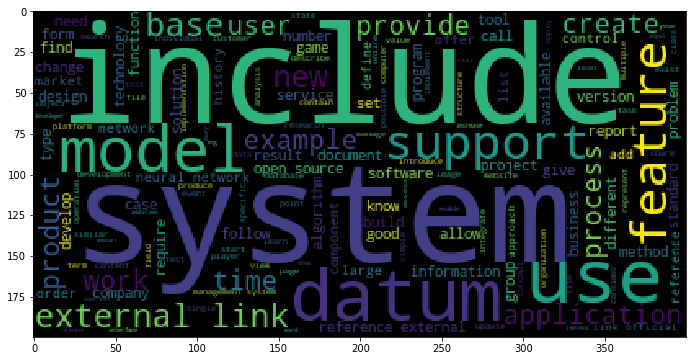

In [39]:
content_wc = WordCloud().generate(' '.join(i for i in page_df['clean_content']))
plt.figure(figsize=(60,6))
plt.imshow(content_wc)
plt.show()

# LSA - Tfidf Vectorizer

In [40]:
tfidf_vectorizer = TfidfVectorizer(min_df = 5, max_df = .95, ngram_range=(1,2), stop_words = "english")

In [41]:
document_term_matrix_sps = tfidf_vectorizer.fit_transform(page_df.clean_content)

In [42]:
document_term_matrix_sps.shape

(5210, 61138)

# SVD

In [43]:
n_components = 400
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [44]:
latent_semantic_analysis = SVD.fit_transform(document_term_matrix_sps)

In [45]:
latent_semantic_analysis[:4]

array([[ 0.23036039, -0.02374698, -0.04563909, ..., -0.00270876,
         0.00969855, -0.0023919 ],
       [ 0.17254343,  0.04540688, -0.02610392, ...,  0.01257161,
         0.03261425, -0.01960268],
       [ 0.13433677,  0.06417026,  0.02045172, ..., -0.00384557,
         0.0231709 , -0.0048189 ],
       [ 0.27411195,  0.22843956,  0.01322415, ...,  0.00405273,
        -0.00339429, -0.00914927]])

In [100]:
search_term = "artificial intelligence"

In [101]:
search_term_vec = tfidf_vectorizer.transform([search_term])
search_term_lsa = SVD.transform(search_term_vec)

In [102]:
search_term_vec.shape

(1, 61138)

In [103]:
cosine_similarities = latent_semantic_analysis.dot(search_term_lsa.T).ravel()

In [104]:
five = cosine_similarities.argsort()[:-6:-1]

In [105]:
for p in five:
    print(p, ":", page_df['title'][p])

491 : Mexican International Conference on Artificial Intelligence
84 : Glossary of artificial intelligence
483 : European Conference on Artificial Intelligence
845 : Marcus Hutter
893 : Jürgen Schmidhuber
